# Tutorial on Mobility

This notebook explains different ways in which the effects of mobility can be simulated with Sionna's [ray tracing (RT) module](https://nvlabs.github.io/sionna/rt/index.html). You will

- Use the `position` and `orientation` properties to move scene objects
- Understand the `velocity` property of scene objects and their impact on the Doppler shift
- Learn how to use the `doppler` property of a `Paths` object to simulate time evolution of channels

## Background Information

There are two ways in which we can simulate the impact of movement of scene objects on the channel impulse response. The first consists in moving the desired objects in small steps along a trajectory and recomputing the propagation paths for each step. While this approach is the most accurate, it comes at the cost of high computational complexity. As we will see later in this notebook, this approach is fortunately not necessary when the lengths of the considered trajectories are small, i.e., not more than a few wavelengths. In this case, we can compute the time evolution of the channel impulse response using the second approach which is based on the experienced Doppler shifts of all propagation paths. It is very fast and leads to very accurate predictions in many cases.

In order to compute the Doppler shift for a specific path as shown in the figure below, Sionna RT relies on the [velocity vectors](https://nvlabs.github.io/sionna/rt/api/scene_object.html#sionna.rt.SceneObject.velocity) of the scene objects. 

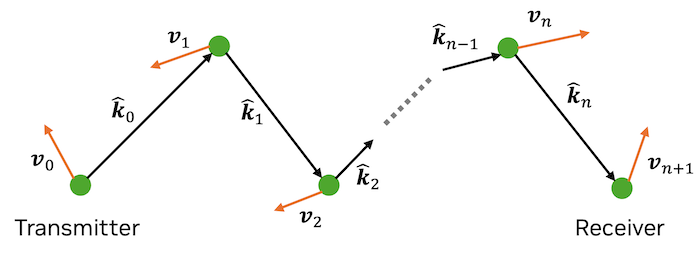

While traveling from the transmitter to the receiver, the path undergoes $n$ scattering processes, such as reflection, refraction, diffuse scattering, or diffraction. The object on which lies the $i$th scattering point has the velocity vector $\mathbf{v}_i$ and the outgoing ray direction at this point is denoted $\hat{\mathbf{k}}_i$. The first and last point correspond to the transmitter and receiver, respectively. 

The Doppler shift $f_\Delta$ for this path can be computed as (see the [documentation](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.doppler) of `Paths.doppler`)

\begin{align}
f_\Delta = \frac{1}{\lambda}\left[\mathbf{v}_{0}^\mathsf{T}\hat{\mathbf{k}}_0 - \mathbf{v}_{n+1}^\mathsf{T}\hat{\mathbf{k}}_n + \sum_{i=1}^n \mathbf{v}_{i}^\mathsf{T}\left(\hat{\mathbf{k}}_i-\hat{\mathbf{k}}_{i-1} \right) \right] \qquad \text{[Hz]}
\end{align}

where $\lambda$ is the wavelength, and then be used to compute the time evolution of the path coefficient `Paths.a`
as

\begin{align}
a(t) = a e^{j2\pi f_\Delta t}.
\end{align}


## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      RadioMapSolver, PathSolver
from sionna.rt.utils import r_hat, subcarrier_frequencies

## Controlling Position and Orientation of Scene Objects

Every object in a scene has a `position` and `orientation` property that can be inspected and modified.
To see this, let us load a scene consisting of a simple street canyon and a few cars.

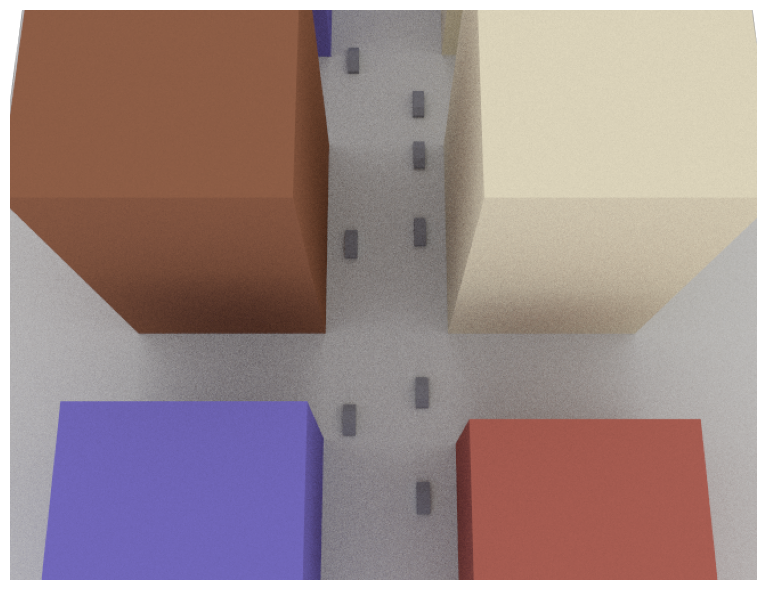

In [2]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam = Camera(position=[50,0,130], look_at=[10,0,0])

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

The list of all scene objects can be accessed as follows:

In [3]:
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x259f7cebfa0>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x259f7ceaf20>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x259f7ce8d60>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x259f7ce8be0>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x259f7ce8760>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x259f7ce8610>,
 'car_1': <sionna.rt.scene_object.SceneObject at 0x259f7ceb280>,
 'car_2': <sionna.rt.scene_object.SceneObject at 0x259f7ceb220>,
 'car_3': <sionna.rt.scene_object.SceneObject at 0x259f7ce9990>,
 'car_4': <sionna.rt.scene_object.SceneObject at 0x259f7cea7a0>,
 'car_5': <sionna.rt.scene_object.SceneObject at 0x259f7ce9b10>,
 'car_6': <sionna.rt.scene_object.SceneObject at 0x259f7ce8280>,
 'car_7': <sionna.rt.scene_object.SceneObject at 0x259f7cea440>,
 'car_8': <sionna.rt.scene_object.SceneObject at 0x259f7ceb3d0>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x259f7ceaa

Let us now inspect the position and orientation of one of the cars:

In [4]:
car_2 = scene.get("car_2")
print("Position: ", car_2.position.numpy()[:,0])
print("Orientation: ", car_2.orientation.numpy()[:,0])

Position:  [25.         5.5999994  0.7500001]
Orientation:  [0. 0. 0.]


The position of an object corresponds to the center of its axis-aligned bounding box.
By default, the orientation of every scene object is `[0,0,0]`. 
We can now change the position and orientation of the car as follows:

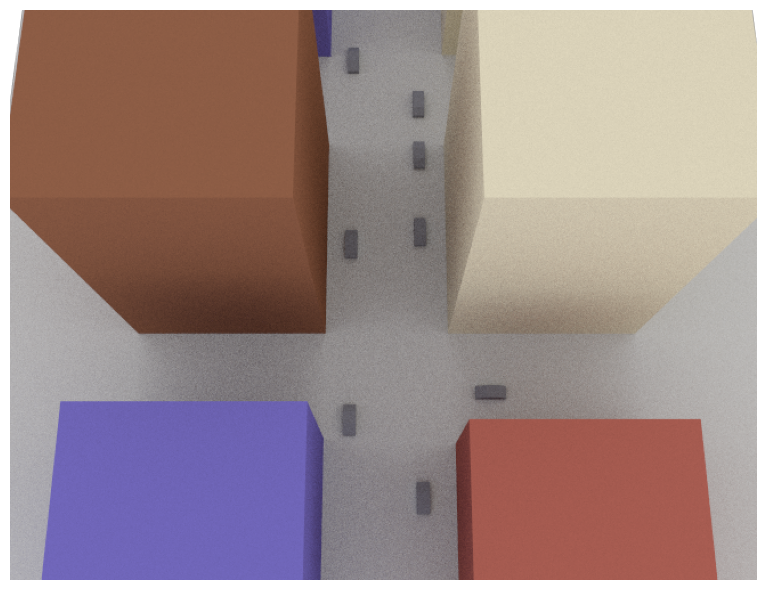

In [5]:
# Move the car 10m along the y-axis
car_2.position += [0, 10, 0]

# And rotate it by 90 degree around the z-axis
car_2.orientation = [np.pi/2, 0, 0]

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

Next, we will visualize coverage maps for different positions of the cars in the scene, assuming that one of the cars is equipped with a transmit antenna:

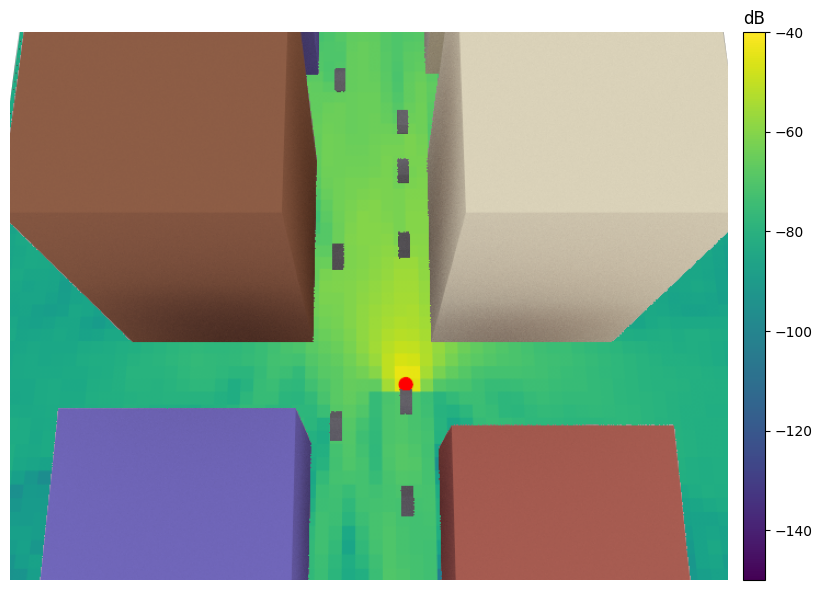

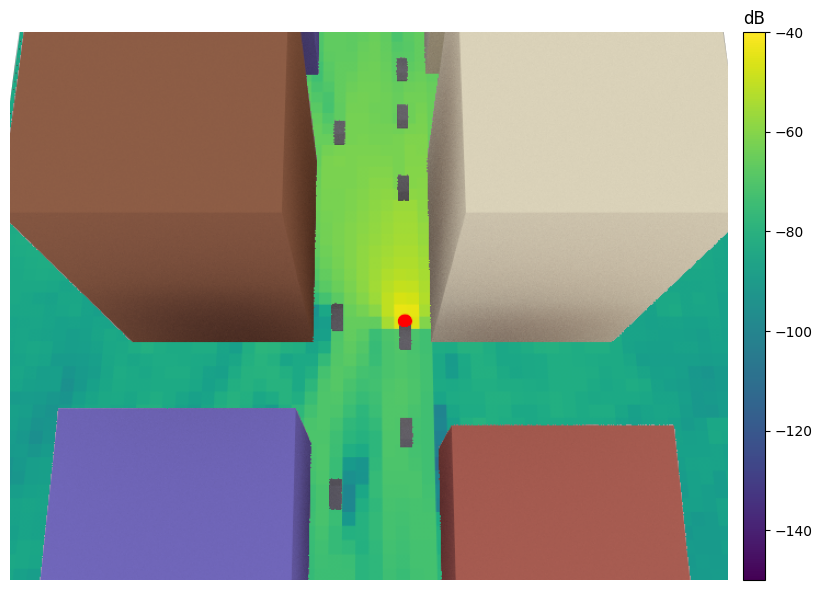

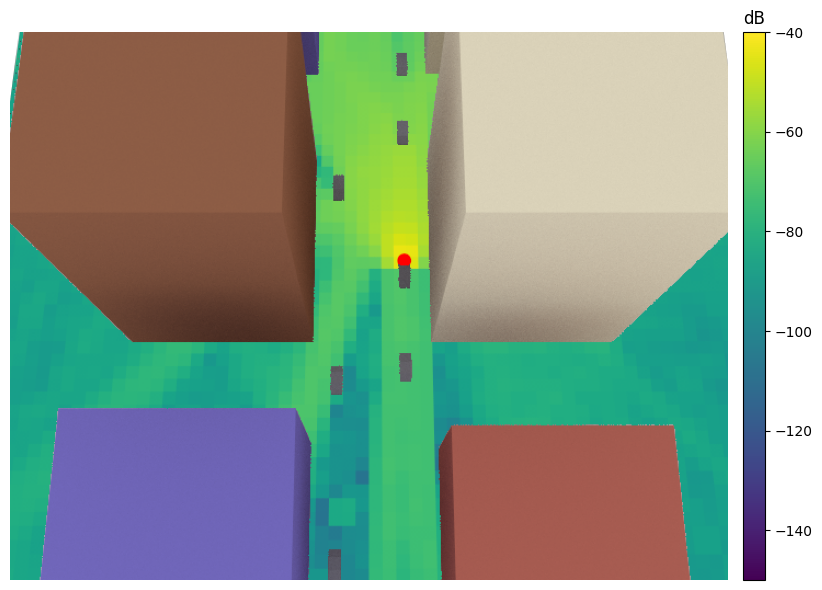

In [6]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam =  Camera(position=[50,0,130], look_at=[10,0,0])

# Configure a transmitter that is located at the front of "car_2"
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="tr38901", polarization="V")
scene.rx_array = scene.tx_array

# Create radio map solver
rm_solver = RadioMapSolver()

# Move cars along straight lines for a couple of steps
displacement_vec = [10, 0, 0]
num_displacements = 2
for _ in range(num_displacements+1):

    # Compute and render a coverage map at 0.5m above the ground
    rm = rm_solver(scene=scene,
                   samples_per_tx=20**6,
                   refraction=True,
                   max_depth=10,
                   center=[0,0,0.5],
                   orientation=[0,0,0],
                   size=[186,121],
                   cell_size=[2,2])
    scene.render(camera=cam, radio_map=rm,
                 num_samples=512, rm_show_color_bar=True,
                 rm_vmax=-40, rm_vmin=-150)

    # Move TX to next position
    scene.get("tx").position -= displacement_vec

    # Move cars driving in -x direction
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in x direction
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

## Time Evolution of Channels Via Doppler Shift

In the previous section, we have seen how the position and orientation of objects in a scene can be modified. However, if we want to model the evolution of channels over very short time horizons, this approach becomes impractical. An alternative, consists in assigning to all moving objects
a velocity vector $\mathbf{v}_i\in\mathbb{R}^3$ based on which path-wise Doppler shifts can be computed. Let us now load a simple scene with a single reflector and modify its velocity.

In [7]:
# Load scene with a single reflector
scene = load_scene(sionna.rt.scene.simple_reflector,
                   merge_shapes=False)
# Inspect the velocity of this object
print("Velocity vector: ", scene.get("reflector").velocity.numpy()[:,0])

# Update velocity vector
scene.get("reflector").velocity = [0, 0, -20]
print("Velocity vector after update: ", scene.get("reflector").velocity.numpy()[:,0])

Velocity vector:  [0. 0. 0.]
Velocity vector after update:  [  0.   0. -20.]


Next, we will add a transmitter and receiver to the scene and compute the propagation paths:

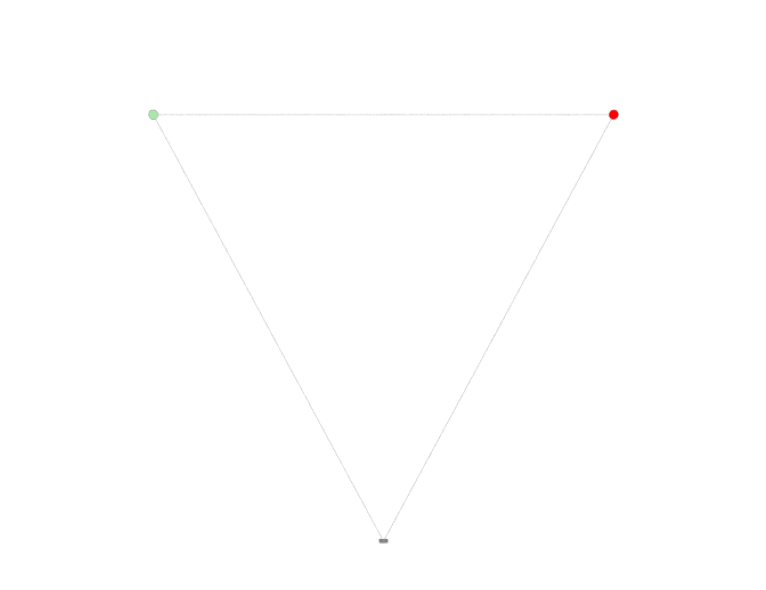

In [8]:
# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(num_rows=1,num_cols=1,pattern="iso", polarization="V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [-25,0.1,50]))
scene.add(Receiver("rx",    [ 25,0.1,50]))

# Compute paths
p_solver = PathSolver()
paths = p_solver(scene=scene, max_depth=1)

# Visualize the scene and propagation paths
if no_preview:
    cam = Camera(position=[0, 100, 50], look_at=[0,0,30])
    scene.render(camera=cam, paths=paths);
else:
    scene.preview(paths=paths)

Every path has a property `Paths.doppler` that corresponds to the aggregated Doppler shift due to the movement of objects it intersects as well as the velocity of the transmitter and receiver.

In [9]:
print("Path interaction (0=LoS, 1=Specular reflection): ", paths.interactions.numpy())
print("Doppler shifts (Hz): ", paths.doppler.numpy())

Path interaction (0=LoS, 1=Specular reflection):  [[[[0 1]]]]
Doppler shifts (Hz):  [[[   0.      -417.68835]]]


### Example: Delay-Doppler Spectrum

We will now use the Doppler shifts to compute a time-varying channel impulse response and estimate its Delay-Doppler spectrum.
To this end, we assume that 1024 subsequent symbols of an OFDM system with 1024 subcarriers can be observed, assuming a subcarrier spacing of 30kHz. This will define the following resolutions in the delay and Doppler domains:

In [10]:
num_ofdm_symbols = 1024
num_subcarriers = 1024
subcarrier_spacing = 30e3

ofdm_symbol_duration = 1/subcarrier_spacing
delay_resolution = ofdm_symbol_duration/num_subcarriers
doppler_resolution = subcarrier_spacing/num_ofdm_symbols

print("Delay   resolution (ns): ", int(delay_resolution/1e-9))
print("Doppler resolution (Hz): ", int(doppler_resolution))

Delay   resolution (ns):  32
Doppler resolution (Hz):  29


In addition to the velocity of the reflector, we also assume that the transmitter is moving. 

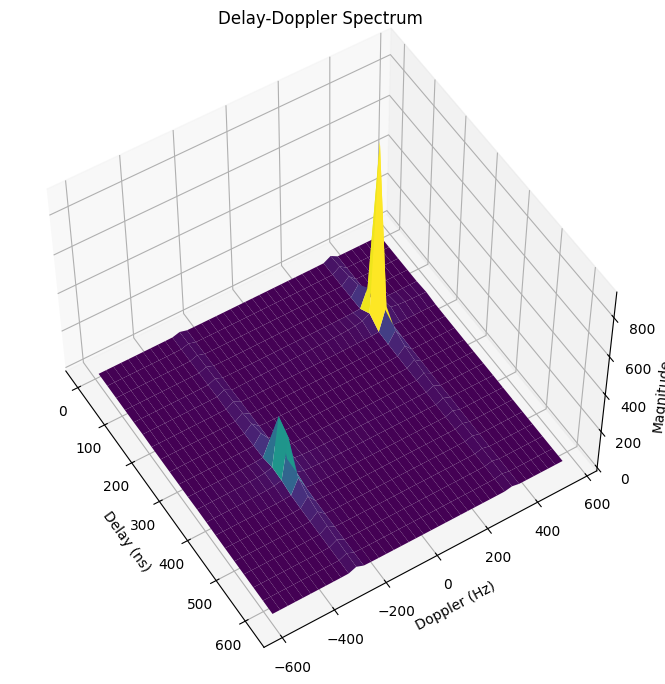

In [11]:
# Set TX velocity
tx_velocity = [30, 0, 0]
scene.get("tx").velocity = tx_velocity

# Recompute the paths
paths = p_solver(scene=scene, max_depth=1, refraction=False)

# Compute channel frequency response with time evolution
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

h = paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              num_time_steps=num_ofdm_symbols,
              normalize_delays=False, normalize=True, out_type="numpy")


### Compute the Delay-Doppler spectrum

# Squeeze useless dimensions
# [num_time_steps, fft_size]
h = np.squeeze(h)

# Apply an FFTshift to bring subcarriers in the
# correct order for an IFFT
h = np.fft.fftshift(h, axes=1)

# Apply IFFT to subcarrier dimension to
# convert frequency to delay domain
h_delay = np.fft.ifft(h, axis=1, norm="ortho")

# Apply FFT to time-step dimension to
# convert time to Doppler domain
h_delay_doppler = np.fft.fft(h_delay, axis=0, norm="ortho")

# Apply FFTShift to bring Doppler dimension in the correct
# order for visualization
h_delay_doppler = np.fft.fftshift(h_delay_doppler, axes=0)

# Compute meshgrid for visualization of the Delay-Doppler spectrum
doppler_bins = np.arange(-num_ofdm_symbols/2*doppler_resolution,
                          num_ofdm_symbols/2*doppler_resolution,
                         doppler_resolution)

delay_bins = np.arange(0,
                       num_subcarriers*delay_resolution,
                       delay_resolution) / 1e-9

x, y = np.meshgrid(delay_bins, doppler_bins)

# Visualize Delay-Doppler spectrum
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# We only visualize the relevant part of the spectrum
offset = 20
x_start = int(num_subcarriers/2)-offset
x_end = int(num_subcarriers/2)+offset
y_start = 0
y_end = offset
x_grid = x[x_start:x_end,y_start:y_end]
y_grid = y[x_start:x_end,y_start:y_end]
z_grid = np.abs(h_delay_doppler[x_start:x_end,y_start:y_end])

surf = ax.plot_surface(x_grid,
                       y_grid,
                       z_grid,
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Doppler (Hz)')
ax.set_zlabel('Magnitude');
ax.zaxis.labelpad=2
ax.view_init(elev=53, azim=-32)
ax.set_title("Delay-Doppler Spectrum");

As expected, we can observe two peaks in the Delay-Doppler spectrum above. The first at a delay of around 160ns, and the second at a delay of approximately 370ns. The respective Doppler shifts are around 350Hz and -260Hz.

The exact Doppler shifts based on the equation provided in the [Background Information](#Background-Information) that should match the peaks in the Delay-Doppler spectrum:

In [12]:
print("Delay - LoS Path (ns) :", paths.tau[0,0,0]/1e-9)
print("Doppler - LoS Path (Hz) :", paths.doppler[0,0,0])

print("Delay - Reflected Path (ns) :", paths.tau[0,0,1].numpy()/1e-9)
print("Doppler - Reflected Path (Hz) :", paths.doppler[0,0,1])

Delay - LoS Path (ns) : 166.782
Doppler - LoS Path (Hz) : 350.242
Delay - Reflected Path (ns) : 372.93597188181593
Doppler - Reflected Path (Hz) : -261.056


## Comparison of Doppler- vs Position-based Time Evolution

We will now compare a time-varying channel frequency impulse response generated by the application of Doppler shifts against another one obtained by physically moving objects in a scene and retracing the paths.

The same scene as in the first section will be used where a transmitter is placed on a moving car. However, we now also place a receiver on another car and assume that all cars in the scene are moving along a linear trajectory.

In [13]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam = Camera(position=[50,0,130], look_at=[10,0,0])

# Parameters for ray tracing
max_depth = 3
refraction = False # Toggle to true to see the impact of refraction
diffraction = False # Toggle to true to see the impact of diffraction

# TX and RX have directional antennas
scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="tr38901", polarization="V")
scene.rx_array = scene.tx_array

# TX and RX are installed at the front of two different cars.
# The directive antennas ensure that paths reaching an antenna from the back are close to zero.
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.add(Receiver("rx", position=[-27.8,-4.9, 0.75]))

# Configure an OFDM resource grid
num_ofdm_symbols = 25
num_subcarriers = 1024
subcarrier_spacing = 30e3
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)
ofdm_symbol_duration = 1/subcarrier_spacing

# Define a velocity vector and the corresponding displacement over the duration
# of one OFDM symbol
velocity_vec = np.array([10,0,0])
displacement_vec = velocity_vec*ofdm_symbol_duration

# Assign velocity vector to cars driving in -x direction
for j in range(1,6):
    scene.get(f"car_{j}").velocity = -velocity_vec

# Assign velocity vector to cars driving in x direction
for j in range(6,9):
    scene.get(f"car_{j}").velocity = velocity_vec

# Compute paths
scene.get("tx").velocity = -velocity_vec
scene.get("rx").velocity = velocity_vec

paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)

# Compute the corresponding channel frequency responses with time evolution
h_dop = paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              num_time_steps=num_ofdm_symbols,
              normalize_delays=False, out_type="numpy")
h_dop = np.squeeze(h_dop)


# Visualize the scene and propagation paths
if no_preview:
    scene.render(camera=cam, paths=paths, num_samples=512);
else:
    scene.preview(paths=paths)

TypeError: PathSolver.__call__() got an unexpected keyword argument 'diffraction'

In the next cell, we compute a sequence of channel frequency responses by moving all cars as well as the transmitter and receiver in the scene. After each step, propagation paths are traced and the corresponding channel frequency response is computed.

In [ ]:
paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
h_sim = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

for i in range(num_ofdm_symbols-1):
    # Move TX and RX to next position
    scene.get("tx").position -= displacement_vec
    scene.get("rx").position += displacement_vec

    # Move cars driving in -x direction to the next position
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in +x direction to the next position
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

    # Compute channel frequency response
    paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
    h = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

    # Concatenate along the time dimensions
    h_sim = np.concatenate([h_sim, h], axis=0)

Next, we visualize the the time evolution of a few subcarriers as well as some snapshots of the full channel frequency response.

In [ ]:
subcarriers = np.arange(0, 1024, 256)
timesteps =  [0, 8, 16, 24]

fig, axs = plt.subplots(4, 4, figsize=(17, 13))
for i,j in enumerate(subcarriers):
    axs[0,i].plot(np.arange(num_ofdm_symbols), np.real(h_sim[:,j]))
    axs[0,i].plot(np.arange(num_ofdm_symbols), np.real(h_dop[:,j]), "--")
    axs[0,i].set_xlabel("Timestep")
    axs[0,i].set_ylabel(r"$\Re\{h(f,t)\}$")
    axs[0,i].set_title(f"Subcarrier {j}")
    axs[0,i].legend(["Movement", "Doppler"])

for i,j in enumerate(subcarriers):
    axs[1,i].plot(np.arange(num_ofdm_symbols), np.imag(h_sim[:,j]))
    axs[1,i].plot(np.arange(num_ofdm_symbols), np.imag(h_dop[:,j]), "--")
    axs[1,i].set_xlabel("Timestep")
    axs[1,i].set_ylabel(r"$\Im\{h(f,t)\}$")
    axs[1,i].set_title(f"Subcarrier {j}")
    axs[1,i].legend(["Movement", "Doppler"])

for i,j in enumerate(timesteps):
    axs[2,i].plot(np.arange(num_subcarriers), np.real(h_sim[j,:]))
    axs[2,i].plot(np.arange(num_subcarriers), np.real(h_dop[j,:]), "--")
    axs[2,i].set_xlabel("Subcarrier")
    axs[2,i].set_ylabel(r"$\Re\{h(f,t)\}$")
    axs[2,i].set_title(f"Timestep {j}")
    axs[2,i].legend(["Movement", "Doppler"])

for i,j in enumerate(timesteps):
    axs[3,i].plot(np.arange(num_subcarriers), np.imag(h_sim[j,:]))
    axs[3,i].plot(np.arange(num_subcarriers), np.imag(h_dop[j,:]), "--")
    axs[3,i].set_xlabel("Subcarrier")
    axs[3,i].set_ylabel(r"$\Im\{h(f,t)\}$")
    axs[3,i].set_title(f"Timestep {j}")
    axs[3,i].legend(["Movement", "Doppler"])

plt.tight_layout()
plt.show()

From the figures above, we can see that there is no noticeable difference
between the Doppler-based channel evolution and the one based on physically
moving objects. However, if refraction and diffraction are enabled or longer
time-horizons are considered, the Doppler-based time-evolution becomes less
accurate because some path may (dis-)appear and their path coefficients and
delays change. You can investigate this yourself by running the cells of this section
with different parameters.

## Summary
We have discussed two different ways to simulate mobility in Sionna RT. One can either move objects in a scene and recompute paths or compute the time evolution of channels synthetically based on the Doppler shifts that are obtained from velocity vectors of the scene objects.

The former approach is computationally intensive but accurate while the latter is much faster but only accurate over short time spans during which the scene objects have moved very short distances. The accuracy also depends strongly on the scenario.

Both approaches can be combined to simulate mobility over longer periods of time.

We hope you enjoyed our dive into the simulation of mobility with Sionna RT. You may also want to explore our other [tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html).